In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.options.display.max_columns=100

For each of 4 wines there are 3 duplicates each with 5 data files (A-E which each have 16 columns: 4 replicates of 4 selectors). AND then also multiple exposures for each (seen 7). <br>
1) Cluster by selectors (the full time series, are there three seperates groups? <br>
2) cluster by wines (Are there 4 seperate groups) by selector  <br> 

Classifiers: K-nn, K-means, logistic regression/SVM (on all or select features)

Read in data and make data in more managable form
Data organization: dictionary of wines -> A-E files in one matrix.<br>
start with just the first exposure:

In [5]:
norm_loc = '.\\normalized_data\\'
files = os.listdir(norm_loc)

wines = {'w01':[], 'w02':[], 'w03':[],
         'w04':[], 'w05':[], 'w06':[],
         'w07':[], 'w08':[], 'w09':[],
         'w10':[], 'w11':[], 'w12':[]}

mapper = {
'A':{1:'S1', 2:'S1', 3:'S1', 4:'S1',
     5:'S2', 6:'S2', 7:'S2', 8:'S2', 
     9:'S3', 10:'S3', 11:'S3', 12:'S3',
     13:'S4', 14:'S4', 15:'S4', 16:'S4'},
'B':{1:'S5', 2:'S5', 3:'S5', 4:'S5',
     5:'S6', 6:'S6', 7:'S6', 8:'S6', 
     9:'S7', 10:'S7', 11:'S7', 12:'S7',
     13:'S8', 14:'S8', 15:'S8', 16:'S8'},
'C':{1:'S9', 2:'S9', 3:'S9', 4:'S9',
     5:'S10', 6:'S10', 7:'S10', 8:'S10', 
     9:'S11', 10:'S11', 11:'S11', 12:'S11',
     13:'S12', 14:'S12', 15:'S12', 16:'S12'},
'D':{1:'S13', 2:'S13', 3:'S13', 4:'S13',
     5:'S14', 6:'S14', 7:'S14', 8:'S14', 
     9:'S15', 10:'S15', 11:'S15', 12:'S15',
     13:'S16', 14:'S16', 15:'S16', 16:'S16'},
'E':{1:'S17', 2:'S17', 3:'S17', 4:'S17',
     5:'S18', 6:'S18', 7:'S18', 8:'S18', 
     9:'S19', 10:'S19', 11:'S19', 12:'S19',
     13:'S20', 14:'S20', 15:'S20', 16:'S20'}
}

#Neither of these are used currently:
exposures = {'1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], '8':[]}
all_data = {}

for f in files:
    f = norm_loc + f 
    selector_group = f[-6] 
    wine = 'w'+f[-9:-7] 
    to_replace = mapper[selector_group]
    data_set = pd.read_excel(f, sheetname=None, header=None) # need to change sheetname to sheet_name for newer pd! ie if V runs
    for key in data_set.iterkeys():
        data_set[key] = data_set[key].set_index(0)
        data_set[key] = data_set[key].rename(columns=to_replace)
#     all_data[wine+selector_group] = data_set
    wines[wine].append(data_set['Sheet1']) # Currently working with just the first exposure
for wine in wines:  
    wines[wine] = pd.concat(wines[wine], axis=1)
# #         exp = key[-1]
#         exposures[exp].append(data_set[key])

In [6]:
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt

Selector number: 1


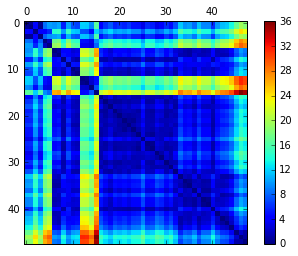

Selector number: 2


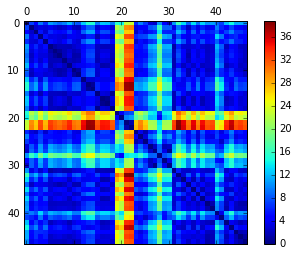

Selector number: 3


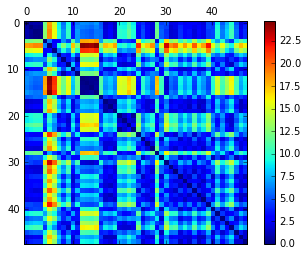

Selector number: 4


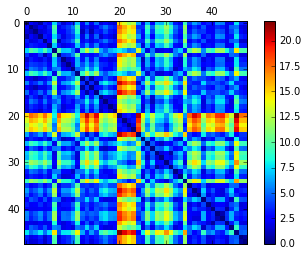

Selector number: 5


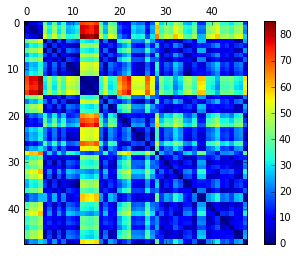

Selector number: 6


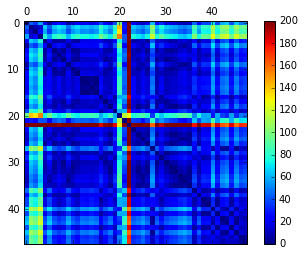

Selector number: 7


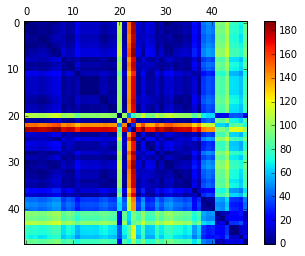

Selector number: 8


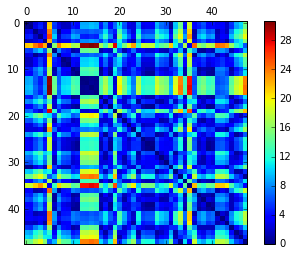

Selector number: 9


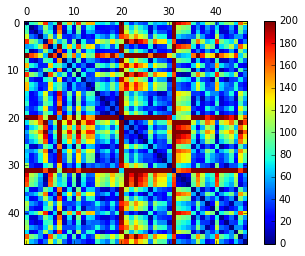

Selector number: 10


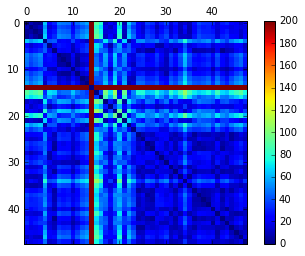

Selector number: 11


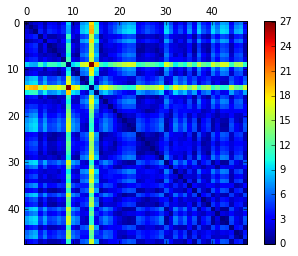

Selector number: 12


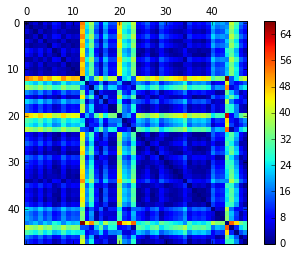

Selector number: 13


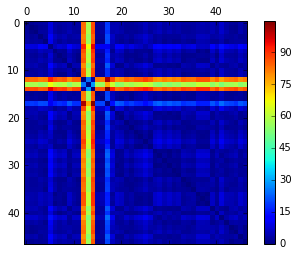

Selector number: 14


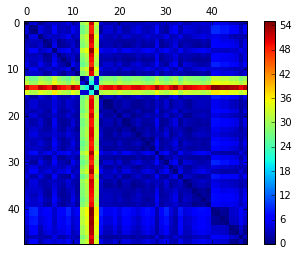

Selector number: 15


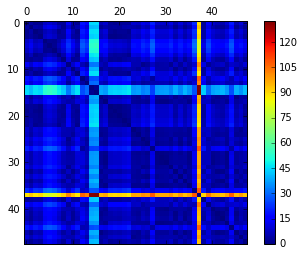

Selector number: 16


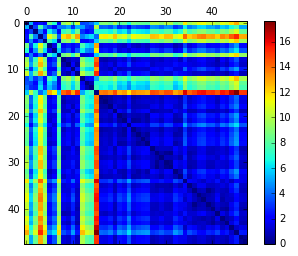

Selector number: 17


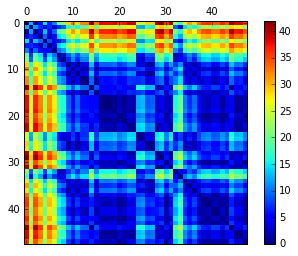

Selector number: 18


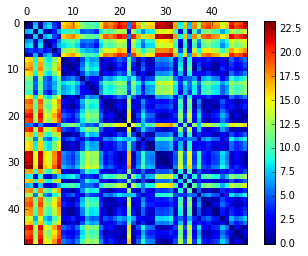

Selector number: 19


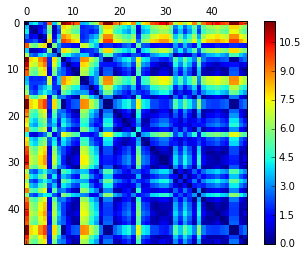

Selector number: 20


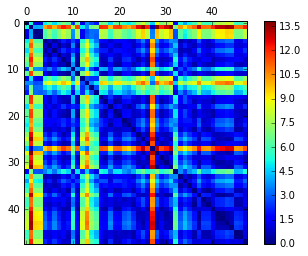

In [15]:
classify = False
plot_dist = True

#get a array for the labels for the wines...there are four wines so four labels
labels = np.array([[1,2,3,4]])
labels = np.repeat(labels, 12, axis=1).flatten()

# see if you can classify with individual selectors (take all 4 of 1 selectors for each wine)
for i in range(1,21):
    selector = []
    # get all the selector data (OF ONE SELECTOR) from each wine into one list
    for w in sorted(wines.keys()):
        selector.append(wines[w]['S'+str(i)])
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    
    if plot_dist:
        s = np.isnan(selector)[:,0]
        selector = selector[~s]
        selector = selector[:, 300:400]
#         rand_kept = np.random.choice(selector.shape[1], 10)
#         selector = selector[:,rand_kept]
        label_sel = labels[~s]
#         print(label_sel, label_sel.shape)
        dist_lin = pdist(selector)
        dist_sq = squareform(dist_lin)
        dist_sq[dist_sq > 200] = 200
        print('Selector number: {}'.format(i))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(dist_sq) #, interpolation='nearest')
        fig.colorbar(cax)
        plt.show()
    
    if classify:
        ##### could come up with a way to randomly pick which subset of Selector data to dynamically generate the mask_test
        ##### Then could iterate multiple times...
        ##### But this is showing ZERO signal currently...
        
        # optional: randomly choose X of the features in the dataset...
        selector = selector[:, 300:450]
#         rand_kept = np.random.choice(selector.shape[1], 50)
#         selector = selector[:,rand_kept]
        # idea is to keep the 4 'replicates' from one sening expt together
        # (ie for wine 1 (made up of w1,w2 and w3, use all of w1's data for say S1 if thats what you are on for testing)
#         mask_test = np.asarray([4,5,6,7,12,13,14,15,28,29,30,31])  # use this line for the general training with l1-lr
        mask_test = np.asarray([12,13,14,15]) # use this line for the euclidean distance calcs
        mask_train = [i for i in range(48) if i not in mask_test]
        
        selector_test = selector[mask_test,:]
        selector = selector[mask_train,:]
        labels_test = labels[mask_test]
        labels_train = labels[mask_train]
        
        # some rows have nothing in them so are all nan, remove with this:
        s = np.isnan(selector)[:,0]
#         print(np.argwhere(s==True))
        selector = selector[~s]
        label_sel = labels_train[~s]
        
        for i in range(selector_test.shape[0]):
            print(i)
            for j in range(selector.shape[0]):
                print(j, euclidean(selector_test[i,:], selector[j,:]))
        
# #         print(selector_test.shape, selector.shape, labels_test.shape, label_sel.shape)
#         x_train,y_train = shuffle(selector, label_sel)
#         x_test,y_test = shuffle(selector_test, labels_test)
# #         x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
#         clf = LogisticRegressionCV(cv=3, multi_class='multinomial', scoring='accuracy', penalty='l1', solver='saga').fit(x_train,y_train)
#         print(clf.score(x_test,y_test))
    

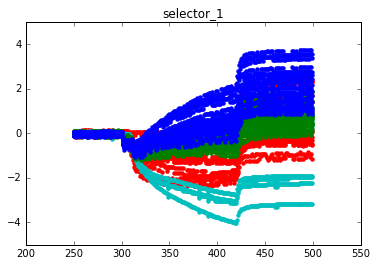

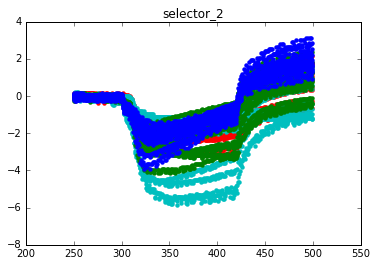

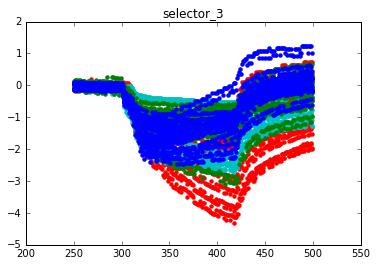

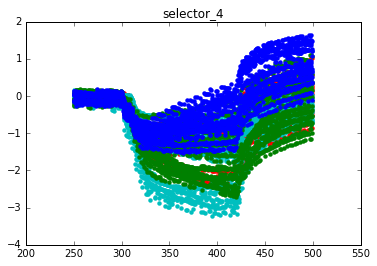

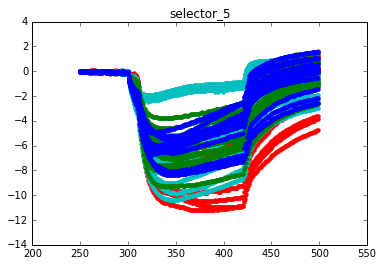

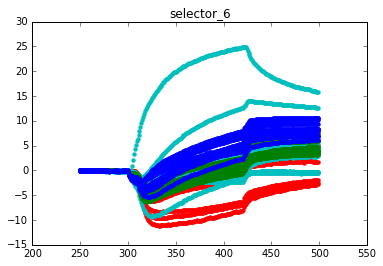

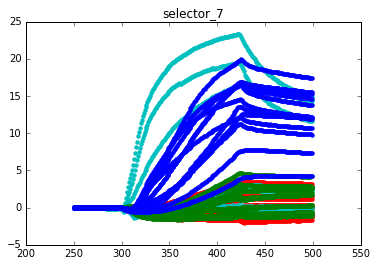

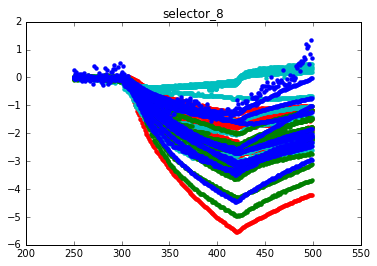

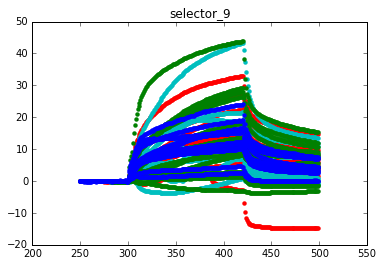

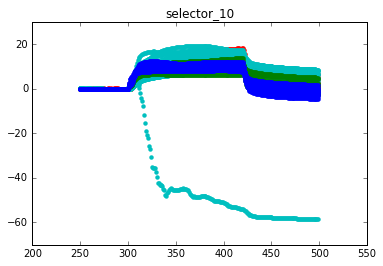

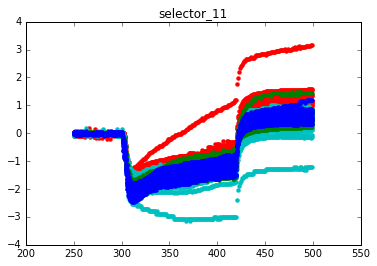

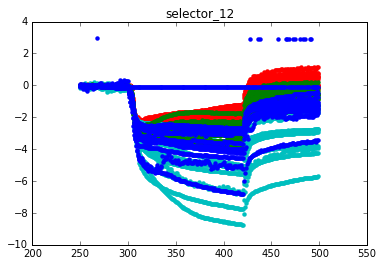

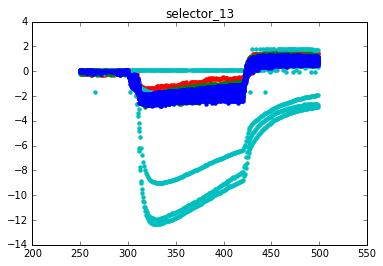

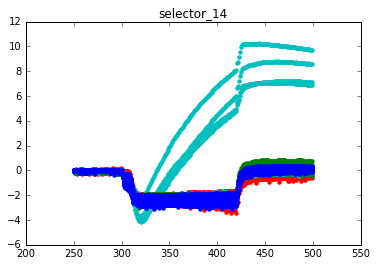

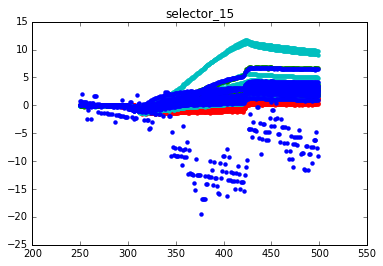

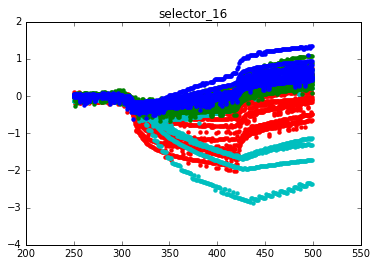

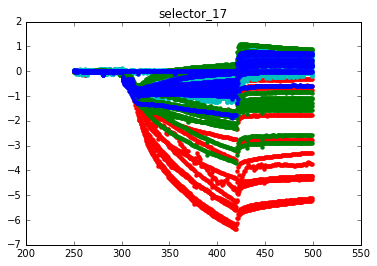

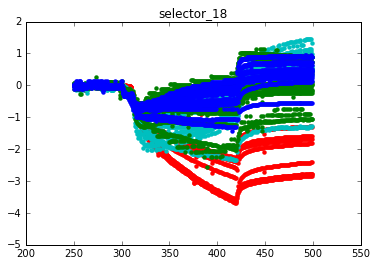

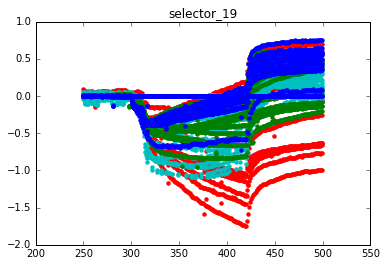

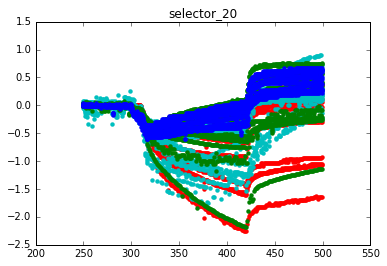

In [13]:
# colors = ['r','r','r','r','b','b','b','b','g','g','g','g','c','c','c','c',
#           'm','m','m','m','y','y','y','y','k','k','k','k','#dcfcbc','#dcfcbc','#dcfcbc','#dcfcbc',
#           '#258487','#258487','#258487','#258487','#c98a84','#c98a84','#c98a84','#c98a84',
#           '#a505d0','#a505d0','#a505d0','#a505d0','#6e54ec','#6e54ec','#6e54ec','#6e54ec']
colors = ['r','r','r','r','r','r','r','r','r','r','r','r',
          'c','c','c','c','c','c','c','c','c','c','c','c',
          'g','g','g','g','g','g','g','g','g','g','g','g',
          'b','b','b','b','b','b','b','b','b','b','b','b']
for i in range(1,21):
    selector = []
    for w in sorted(wines.keys()):
        selector.append(wines[w]['S'+str(i)])
#         internal = wines[w].
    selector = pd.concat(selector, axis=1)
    
    ##### TO plot each selector individually for each wine and replicate (ie just 4 line per plot)
        #### must change the for i in range() line to range(1,2) or 3,4 etc
#     print(selector.shape)
#         plt.scatter(list(selector.index)[300:400], selector.iloc[300:400,i])    
#     for i in range(12):
# #     selector.plot(y='S'+str(i), use_index=True, legend=False)
#         plt.scatter(list(selector.index)[300:400], selector.iloc[300:400,i])
#     plt.show()
#     for i in range(12,24):
# #     selector.plot(y='S'+str(i), use_index=True, legend=False)
#         plt.scatter(list(selector.index)[300:400], selector.iloc[300:400,i])
#     plt.show()
#     for i in range(24,36):
# #     selector.plot(y='S'+str(i), use_index=True, legend=False)
#         plt.scatter(list(selector.index)[300:400], selector.iloc[300:400,i])
#     plt.show()
#     for i in range(36,48):
# #     selector.plot(y='S'+str(i), use_index=True, legend=False)
#         plt.scatter(list(selector.index)[300:400], selector.iloc[300:400,i])
#     plt.show()
    
    
    ### to plot all on one
    for j,c in enumerate(colors):
        y = selector.iloc[:,j].values[250:500]
        x = list(selector.index)[250:500]
        plt.scatter(x,y,c=c, linewidth=0)
    plt.title('selector_{}'.format(i))
    plt.show()



playing around with combining data from different selectors into one large vector: <br>
then (1) classification (2) distance matricies / clustering <br>
Do with and without dropping some (at random), then feature selection

w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
w01
w02
w03
w04
w05
w06
w07
w08
w09
w10
w11
w12
0.166666666667


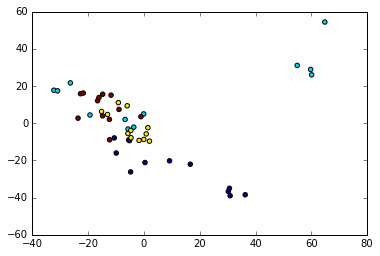

In [12]:
random_drop = False
rand_num = 50
plot_dist = False
classify = True
run_pca = True

labels = np.array([[1,2,3,4]])
labels = np.repeat(labels, 12, axis=1).flatten()

full_data = []
first = True
for i in range(1,21):
    selector = []
    for w in sorted(wines.keys()):
        print(w)
        #################START HERE....NOT FILLING NANs CORRECTLY OR AT ALL NOW....
        selector_data = wines[w]['S'+str(i)]
#         print(selector_data)
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T
#         print(selector_data)
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1) 
    selector = selector.values.T[:,300:400]
    if random_drop:
        if first:
            rand_dropped = np.random.choice(selector.shape[1], rand_num)
            first = False
        selector = selector[:,rand_dropped]
#     selector = selector.reshape((-1,1))
    full_data.append(selector)
full_data = np.concatenate(full_data, axis=1)
# print(full_data.shape)
# full_data[np.isnan(full_data)]=1000

if plot_dist:
#     s = np.isnan(selector)[:,0]
#     selector = selector[~s]
#     selector = selector[:, 300:400]
#     label_sel = labels[~s]
    dist_lin = pdist(full_data)
    dist_sq = squareform(dist_lin)
    dist_sq[dist_sq >200] = 200
    print('Selector number: {}'.format(i))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(dist_sq) #, interpolation='nearest')
    fig.colorbar(cax)
    plt.show()
    
if classify:
    mask_test = np.asarray([0,1,2,3,12,13,14,15,28,29,30,31])
    mask_train = [i for i in range(48) if i not in mask_test]    
    x_test = full_data[mask_test,:]
    x_train = full_data[mask_train,:]
    y_test = labels[mask_test]
    y_train = labels[mask_train]
    x_train, y_train = shuffle(x_train,y_train)
    
    
#     s = np.isnan(full_data)[:,0]
#     full_data= full_data[~s]
#     label_data = labels[~s]
#     X,y = shuffle(full_data, label_data)
#     x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    clf = LogisticRegressionCV(cv=3, multi_class='multinomial', penalty='l1', solver='saga').fit(x_train,y_train)
#     clf = RandomForestClassifier(n_estimators=500).fit(x_train,y_train)
    print(clf.score(x_test,y_test))
    
if run_pca:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    pca = PCA(n_components=4)
    X = ss.fit_transform(full_data)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
    plt.show()

[1 1 1 2 2 2 3 3 3 4 4 4]


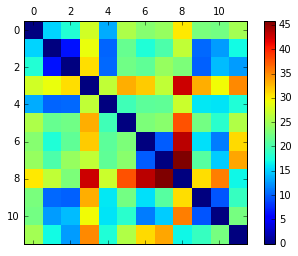

((12L, 400L), (12L,))
0.0


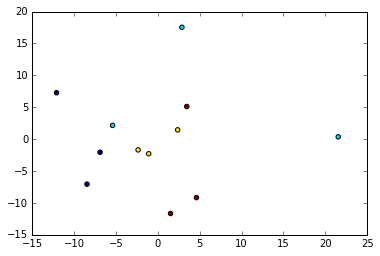

In [11]:
##### trying to average all of the selectors in one wine together....so just 3 vectors for wine 1, 2, 3 and 4
random_drop = False
rand_num = 50
plot_dist = True
classify = True
run_pca = True

labels = np.array([[1,2,3,4]])
labels = np.repeat(labels, 3, axis=1).flatten()
print(labels)

full_data = []
first = True
for i in range(1,21):
    selector = []
    for w in sorted(wines.keys()):
#         print(w)
        #################START HERE....NOT FILLING NANs CORRECTLY OR AT ALL NOW....
        selector_data = wines[w]['S'+str(i)]
        selector_data = selector_data.mean(axis=1)
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1) 
    selector = selector.values.T[:,300:320]
    if random_drop:
        if first:
            rand_dropped = np.random.choice(selector.shape[1], rand_num)
            first = False
        selector = selector[:,rand_dropped]
#     selector = selector.reshape((-1,1))
    full_data.append(selector)
full_data = np.concatenate(full_data, axis=1)

if plot_dist:
#     s = np.isnan(selector)[:,0]
#     selector = selector[~s]
#     selector = selector[:, 300:400]
#     label_sel = labels[~s]
    dist_lin = pdist(full_data)
    dist_sq = squareform(dist_lin)
    dist_sq[dist_sq >200] = 200
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(dist_sq) #, interpolation='nearest')
    fig.colorbar(cax)
    plt.show()
    
if classify:  
    print(full_data.shape, labels.shape)
    X,y = shuffle(full_data, labels)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    clf = LogisticRegressionCV(cv=3, multi_class='multinomial', penalty='l1', solver='saga').fit(x_train,y_train)
#     clf = RandomForestClassifier(n_estimators=100).fit(x_train,y_train)
    print(clf.score(x_test,y_test))
    
if run_pca:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    pca = PCA(n_components=4)
    X = ss.fit_transform(full_data)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:,1], X_pca[:,2], c=labels)
    plt.show()